In [15]:
import numpy as np

import nengo
from nengo.solvers import LstsqL2, NoSolver
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import tuning_curves
from nengo.dists import Uniform
from nengo.params import Default
from nengo.utils.numpy import rmse

from nengolib.signal import s, nrmse, LinearSystem
from nengolib.synapses import Lowpass

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from scipy.signal import convolve
# from scipy.ndimage.filters import convolve

from nengo_bioneurons import BahlNeuron

# Signals

In [16]:
def make_stimulus(signal, freq, amp, seed):       
    if signal == 'cos':
        return nengo.Node(output=lambda t: np.cos(freq*t))
    elif signal == 'sin':
        return nengo.Node(output=lambda t: np.sin(freq*t))
    elif signal == 'white_noise':
        return nengo.Node(nengo.processes.WhiteSignal(
            period=100,
            high=freq,
            rms=amp,
            seed=seed))

In [17]:
def norms(signal, freq, amp, ss, tau, t, plot=False):
    # first find the norm of the filtered signal
    lpf=nengo.Lowpass(tau)
    with nengo.Network() as model:
        stim = make_stimulus(signal, freq, amp, ss)
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t, progress_bar=False)
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = lpf.filt(sim.data[p_integral])
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    
    if plot:
        plt.plot(sim.trange(), stimulus)
        plt.plot(sim.trange(), target)
        plt.plot(sim.trange(), lpf.filt(sim.data[p_integral]/norm_f))
        plt.show()
    return norm, norm_s, norm_f

In [18]:
def bin_activities_values_1d(
    xhat_pre,
    act_bio,
    x_min=-1,
    x_max=1,
    n_neurons=10,
    n_eval_points=20):

    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx

    x_bins = np.linspace(x_min, x_max, num=n_eval_points)
    hz_means = np.empty((n_neurons, n_eval_points))
    hz_stds = np.empty((n_neurons, n_eval_points))
    for i in range(n_neurons):
        bin_act = [[] for _ in range(x_bins.shape[0])]
        for t in range(act_bio.shape[0]):
            idx = find_nearest(x_bins, xhat_pre[t])
            bin_act[idx].append(act_bio[t, i])
        for x in range(len(bin_act)):
            hz_means[i, x] = np.average(bin_act[x])
            hz_stds[i, x] = np.std(bin_act[x])

    return x_bins, hz_means, hz_stds

# Encoder Learning

Goal: learn the encoder at each synapse between "pre" and "bio" such that "bio"'s tuning curve approaches a target tuning curve.

Method: given $d_{pre}$, a desired tuning curve for "bio", and a current estimate for "activity" and $x \cdot e_{bio}$, update $e_{syn}$ to increase or decrease the magnitude of input current.

In [19]:
class EncoderNode(nengo.Node):
    def __init__(
            self,
            conn,
            n_bio,
            n_syn,
            dim,
            d_pre,
            eta,  # learning rate
            seed, # learning seed
            syn_encoders_init):
        
        self.conn = conn
        self.n_syn = n_syn
        self.dim = dim
        self.d_pre = d_pre
        self.eta = eta
        self.rng = np.random.RandomState(seed=seed)
        self.n_pre = self.d_pre.shape[0]
        self.n_bio = n_bio
        self.syn_encoders = syn_encoders_init
        self.syn_weights = np.zeros_like(self.syn_encoders)
        self.a_target = np.array([])
        self.a_bio = np.array([])

        super(EncoderNode, self).__init__(self.update, 
            size_in=2*self.n_bio,  # [a_bio, a_lif]
            size_out=self.n_bio)

    def update(self, t, x):
        self.a_bio = x[0:self.n_bio]
        self.a_target = x[self.n_bio:2*self.n_bio]
        return self.a_bio - self.a_target
    
    def update_encoders(self, bio, pre, syn):
        a_error = self.a_bio[bio] - self.a_target[bio]
        d_syn = self.d_pre[pre]
        e_old = self.syn_encoders[bio, pre, syn]
        delta = self.rng.uniform(0, 2 * self.eta * np.abs(a_error))
        if a_error > 0 and d_syn > 0:  # overactive, positive dec => reduce enc reduce weight
            self.syn_encoders[bio, pre, syn] += -delta
        if a_error > 0 and d_syn < 0:  # overactive, negative dec => increase enc reduce weight
            self.syn_encoders[bio, pre, syn] += +delta
        if a_error < 0 and d_syn > 0:  # underactive, positive dec => increase enc increase weight
            self.syn_encoders[bio, pre, syn] += +delta
        if a_error < 0 and d_syn < 0:  # underactive, negative dec => reduce enc increase weight
            self.syn_encoders[bio, pre, syn] += -delta
        w_new = np.dot(d_syn, self.syn_encoders[bio, pre, syn])
        return w_new

    def update_weights(self):
        for bio in range(self.n_bio):
            for pre in range(self.n_pre):
                for syn in range(self.n_syn):
                    self.syn_weights[bio, pre, syn] = np.dot(self.d_pre[pre], self.syn_encoders[bio, pre, syn])
        return self.syn_weights

## Network

In [20]:
def pre_bio_encoder_opt(
    d_bio_out,
    t=1,
    n_neurons=10,
    n_syn=1,
    signal='sin',
    freq=1,
    amp=1,
    sec='tuft',
    eta=0,
    taus={'network': 0.05,
          'readout': 0.05},
    regs={'pre-bio': 0.1,
          'bio-out': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    neuron_type=BahlNeuron(bias_method='weights_fixed'),
    learning=True,
    syn_weights=None,
    syn_encoders=None,
    plot=True):
    
    norm, norm_s, norm_f = norms(signal, freq, amp, seeds['ss'], taus['network'], t)
    
    pre_kwargs = dict(
        n_neurons=100,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'])
    
    lif_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'],
        label='lif')
    
    conn_kwargs = dict(
        sec=sec,
        n_syn=n_syn,
        syn_type='ExpSyn',
        tau_list=[taus['network']],
        synapse=taus['network'],
        seed=seeds['cs'])
    
    bio_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=Uniform(-1, 1),  # doesn't affect
        gain=Uniform(0, 0),
        bias=Uniform(0, 0),
        neuron_type=neuron_type,
        seed=seeds['es'],
        label='bio')
    
    # Build a network to collect encoders, gains, biases from target LIF
    with nengo.Network(seed=seeds['ns']) as pre_model:
        pre = nengo.Ensemble(**pre_kwargs)
        lif = nengo.Ensemble(**lif_kwargs)
        pre_lif = nengo.Connection(pre, lif, **conn_kwargs)
    sim = nengo.Simulator(pre_model, seed=seeds['ss'])
    d_pre = sim.data[pre_lif].weights.T
    e_target = sim.data[lif].encoders
    syn_encoders_init = np.zeros((n_neurons, 100, n_syn))
    for bio in range(syn_encoders_init.shape[0]):
        syn_encoders_init[bio] = e_target[bio] * np.ones((100, n_syn))
    
    # Simulate the full network with the encoder learning rule
    with nengo.Network(seed=seeds['ns']) as model:
        u = make_stimulus(signal, freq, amp, seeds['ss'])
        pre = nengo.Ensemble(**pre_kwargs)
        bio = nengo.Ensemble(**bio_kwargs)
        lif = nengo.Ensemble(**lif_kwargs)

        nengo.Connection(u, pre, synapse=None, transform=1.0/norm_s, seed=seeds['cs'])
        pre_bio = nengo.Connection(pre, bio, syn_weights=syn_weights, **conn_kwargs)
        pre_lif = nengo.Connection(pre, lif, **conn_kwargs)
        
        if learning:
            enc_node = EncoderNode(
                pre_bio,
                n_neurons,
                n_syn,
                1,
                d_pre,
                eta,  # learning rate
                seeds['ls'], # learning seed
                syn_encoders_init=syn_encoders_init)
            pre_bio.learning_node = enc_node
            nengo.Connection(bio.neurons, enc_node[0:n_neurons], synapse=taus['readout'])  # a_bio
            nengo.Connection(lif.neurons, enc_node[n_neurons:2*n_neurons], synapse=taus['readout'])  # a_lif
        
        p_target = nengo.Probe(u, synapse=None)
        p_spk_bio = nengo.Probe(bio.neurons, synapse=None)
        p_act_bio = nengo.Probe(bio.neurons, synapse=taus['readout'])
        p_act_lif = nengo.Probe(lif.neurons, synapse=taus['readout'])
        p_bio = nengo.Probe(bio, synapse=taus['readout'], solver=NoSolver(d_bio_out))

    with nengo.Simulator(model, seed=seeds['ss']) as sim:
        sim.run(t)

    target = nengo.Lowpass(taus['readout']).filt(sim.data[p_target])
    spikes_bio = sim.data[p_spk_bio]
    act_bio = sim.data[p_act_bio]
    act_lif = sim.data[p_act_lif]
    xhat_bio = sim.data[p_bio]
    nrmse_bio = nrmse(xhat_bio, target=target)
        
    x_bins, hz_means, hz_stds = bin_activities_values_1d(
        target,
        act_bio,
        n_neurons=n_neurons)
    x_bins_lif, hz_means_lif, hz_stds_lif = bin_activities_values_1d(
        target,
        act_lif,
        n_neurons=n_neurons)

    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
        rasterplot(sim.trange(), spikes_bio, ax=ax1)
        ax1.set(xlabel='time', ylabel='neuron')
        sns.distplot(np.ravel(act_bio), ax=ax2)
        ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')

        fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
        ax1.plot(sim.trange(), act_bio, alpha=0.5)
        ax1.set(xlabel='time', ylabel='activity')
        
        cmap = sns.color_palette('hls', n_neurons)
        fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(8, 8), sharey=True)
        for n in range(n_neurons):
            ax4.plot(x_bins_lif, hz_means_lif[n], c=cmap[n])
            ax4.fill_between(x_bins_lif,
                hz_means_lif[n]+hz_stds_lif[n],
                hz_means_lif[n]-hz_stds_lif[n],
                alpha=0.5, facecolor=cmap[n])
            ax5.plot(x_bins, hz_means[n], c=cmap[n])
            ax5.fill_between(x_bins,
                hz_means[n]+hz_stds[n],
                hz_means[n]-hz_stds[n],
                alpha=0.5, facecolor=cmap[n])
        ax4.set(xlim=((-1,1)), ylim=((0, 50)), xlabel='$\mathbf{x}$', ylabel='activity (Hz)', title='lif')
        ax5.set(xlim=((-1,1)), ylim=((0, 50)), xlabel='$\mathbf{x}$', title='bio')
        
        plt.tight_layout()
        plt.show()


    d_bio_out_new = LstsqL2(reg=regs['bio-out'])(act_bio, target)[0]
    syn_weights_new = sim.data[pre_bio].weights
    
#     print 'conn', np.sum(syn_weights_new)
#     if learning:
#         syn_weights_node = enc_node.update_weights()
#         print 'node', np.sum(syn_weights_node)
                
    return d_bio_out_new, syn_weights_new

## Simulation

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:01:58.                                                 


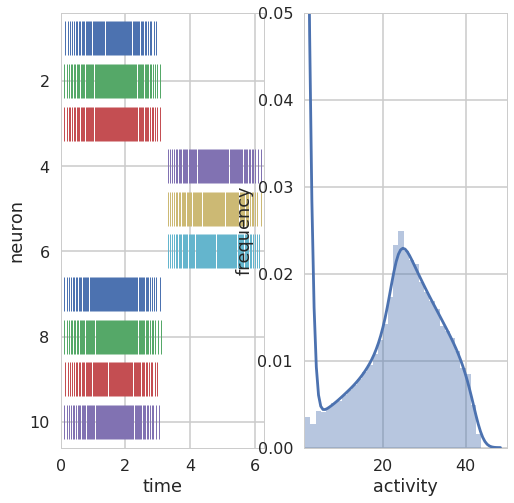

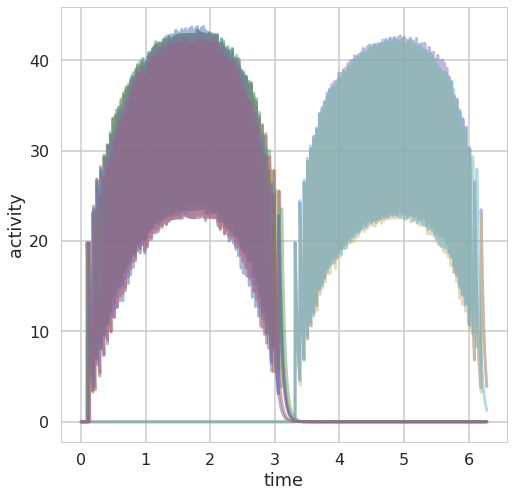

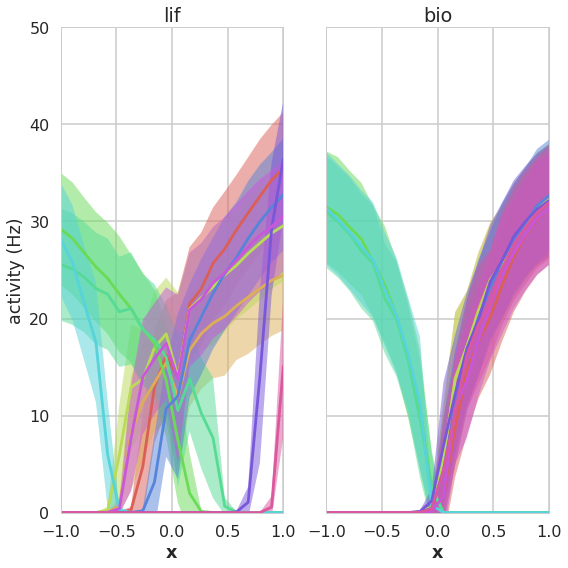

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:15:35.                                                 


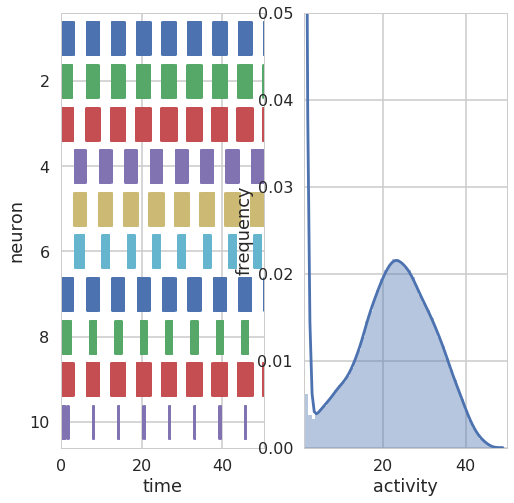

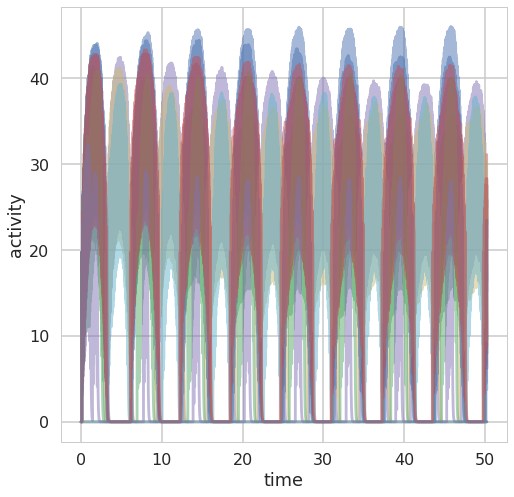

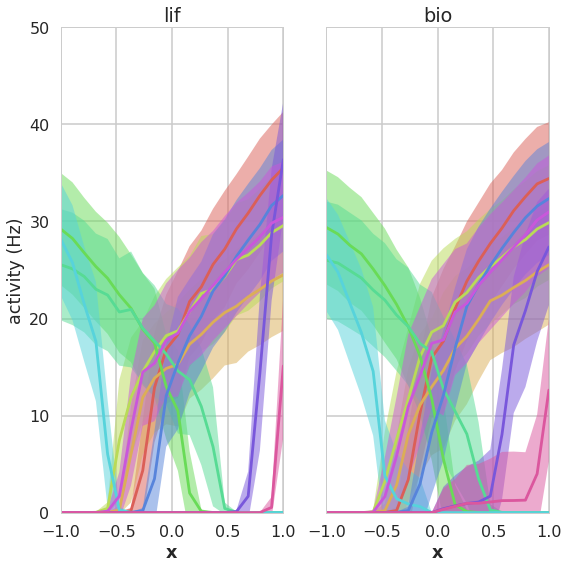

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:03:56.                                                 


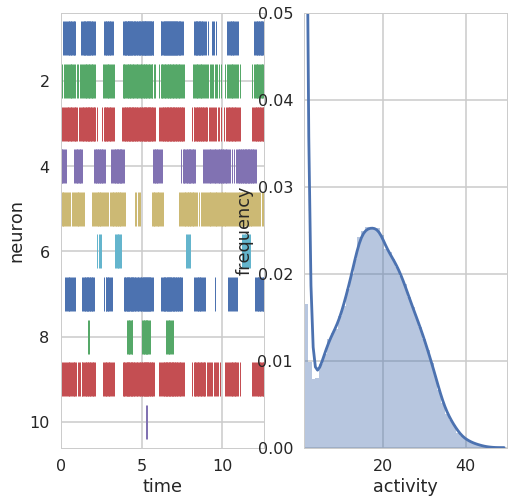

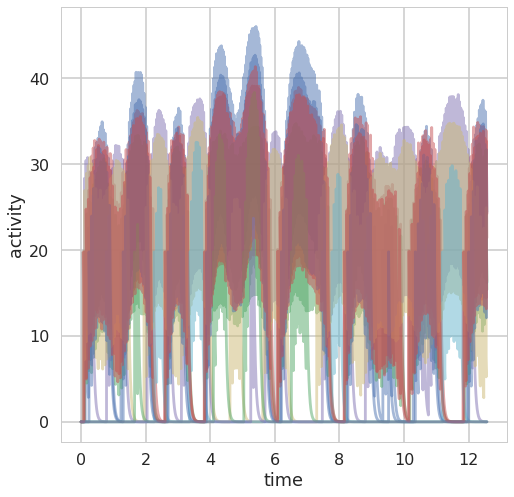

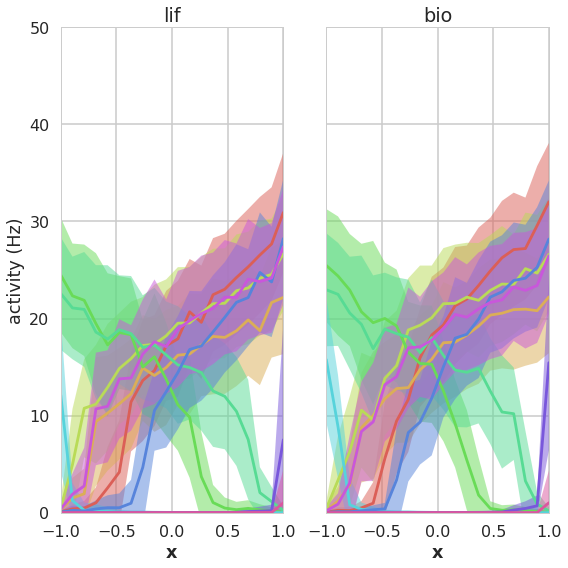

In [21]:
n_neurons = 10
n_syn = 2
freq = 1

d_bio_out_init = np.zeros((n_neurons, 1))
syn_weights_init = np.zeros((n_neurons, 100, n_syn))

_, _ = pre_bio_encoder_opt(
    d_bio_out_init,
    t=2*np.pi,
    freq=freq,
    n_neurons=n_neurons,
    n_syn=n_syn,
    eta=0,
    syn_weights=syn_weights_init,
    plot=True)

_, syn_weights = pre_bio_encoder_opt(
    d_bio_out_init,
    t=16*np.pi,
    freq=freq,
    n_neurons=n_neurons,
    n_syn=n_syn,
    eta=2e-3,
    syn_weights=syn_weights_init,
    plot=True)

_, _ = pre_bio_encoder_opt(
    d_bio_out_init,
    t=4*np.pi,
    freq=freq,
    n_neurons=n_neurons,
    n_syn=n_syn,
    eta=0,
    signal='white_noise',
    syn_weights=syn_weights,
    learning=False,
    plot=True)

# Readout Filter and Decoder Optimization

In [24]:
def optimize_elephys(
    save_data,
    n_neurons,
    tau_lpf,
    n_zeros=0,
    n_poles=1,
    z_min=-1e0,
    z_max=1e0,
    p_min=-1e-1,
    p_max=5e-1,
    reg=0.1,
    max_evals=100,
    normalize=True,
    seed=5):
    
    h_eps = []
    hyps = {}  # hyperparameters
    hyps['save_data'] = save_data
    for bio in range(n_neurons):  # put all bios in one hyperparams so decoder act on all 
        for z in range(n_zeros):
            hyps['%s_bio_%s_zero'%(bio, z)] = hp.uniform('%s_bio_%s_zero'%(bio, z), z_min, z_max)
        for p in range(n_poles):
            hyps['%s_bio_%s_pole'%(bio, p)] = hp.uniform('%s_bio_%s_pole'%(bio, p), p_min, p_max)


    def objective(hyps):
        from nengolib.signal import nrmse
        from nengo.utils.numpy import rmse

        for bio in range(n_neurons):
            zeros = np.array([hyps['%s_bio_%s_zero'%(bio, z)] for z in range(n_zeros)])
            poles = np.array([hyps['%s_bio_%s_pole'%(bio, p)] for p in range(n_poles)])
            h_ep = LinearSystem((zeros, poles, 1.0))
            if normalize:
                h_ep/= h_ep.dcgain
            h_eps.append(h_ep)
                
        spikes = np.load(hyps['save_data'])['spikes']
        act_lpf = nengo.Lowpass(tau_lpf).filt(spikes)
        act_eps = np.zeros_like(act_lpf)
        for n in range(n_neurons):
            act_eps[:,n] = h_eps[n].filt(act_lpf[:,n])
        target = np.load(hyps['save_data'])['target']
        if np.sum(act_eps != 0):
            d_eps = nengo.solvers.LstsqL2(reg=reg)(act_eps, target)[0]
        else:
            d_eps = np.zeros((n_neurons, 1))
        xhat_eps = np.dot(act_eps, d_eps)
        if np.sum(target) != 0: nrmse = nrmse(xhat_eps, target=target)
        else: nrmse = rmse(xhat_eps, target)

        return {'loss': nrmse,
            'h_eps': h_eps,
            'd_eps': d_eps,
            'status': STATUS_OK }

    trials = Trials()

    best = fmin(objective,
                rstate=np.random.RandomState(seed=seed),
                space=hyps,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials)

    best_idx = np.array(trials.losses()).argmin()
    best_h_eps = trials.trials[best_idx]['result']['h_eps']
    best_d_eps = trials.trials[best_idx]['result']['d_eps']

    return best_h_eps, best_d_eps

## Network

In [8]:
def pre_bio_decoder_opt(
    d_lpf,
    d_eps,
    h_eps,
    t=1,
    n_neurons=10,
    n_syn=1,
    signal='sin',
    freq=1,
    amp=1,
    sec='tuft',
    taus={'network': 0.05,
          'readout': 0.05},
    regs={'pre-bio': 0.1,
          'bio-out': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    neuron_type=BahlNeuron(bias_method='weights_fixed'),
    save_dir='/home/pduggins/nengo_bioneurons/nengo_bioneurons/tests/data/double_optimize_zeropole_prebio/',
    save_file='default.npz',
    n_zeros=0,
    n_poles=1,
    z_min=-1e0,
    z_max=1e0,
    p_min=-1e-1,
    p_max=-1e-2,
    optimize=True,
    plot=True):
    
    norm, norm_s, norm_f = norms(signal, freq, amp, seeds['ss'], taus['network'], t)
    
    pre_kwargs = dict(
        n_neurons=100,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'])
    
    conn_kwargs = dict(
        sec=sec,
        n_syn=n_syn,
        syn_type='ExpSyn',
        tau_list=[taus['network']],
        synapse=taus['network'],
        seed=seeds['cs'])
    
    bio_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=Uniform(-1e0,1e0),
        gain=Uniform(-1e2, 1e2),
        bias=Uniform(-2e-4, 2e-4),
        neuron_type=neuron_type,
        seed=seeds['es'],
        label='bio')
    
    with nengo.Network(seed=seeds['ns']) as model:
        u = make_stimulus(signal, freq, amp, seeds['ss'])
        pre = nengo.Ensemble(**pre_kwargs)
        bio = nengo.Ensemble(**bio_kwargs)

        nengo.Connection(u, pre, synapse=None, transform=1.0/norm_s, seed=seeds['cs'])
        pre_bio = nengo.Connection(pre, bio, **conn_kwargs)
        
        p_target = nengo.Probe(u, synapse=None)
        p_spk_bio = nengo.Probe(bio.neurons, synapse=None)
        p_act_bio = nengo.Probe(bio.neurons, synapse=taus['readout'])
        p_bio = nengo.Probe(bio, synapse=taus['readout'], solver=NoSolver(d_lpf))

    with nengo.Simulator(model, seed=seeds['ss']) as sim:
        sim.run(t)

    target = nengo.Lowpass(taus['readout']).filt(sim.data[p_target])
    spikes = sim.data[p_spk_bio]
    act_lpf = sim.data[p_act_bio]
#     xhat_bio = sim.data[p_bio]
    d_lpf = nengo.solvers.LstsqL2(reg=regs['bio-out'])(act_lpf, target)[0]
    xhat_lpf = np.dot(act_lpf, d_lpf)
    nrmse_lpf = nrmse(xhat_lpf, target=target)
    
    if optimize:  # solve for h_elephys and d_elephys
        np.savez(save_dir+save_file, spikes=spikes, target=target)
        h_eps, d_eps = optimize_elephys(
            save_dir+save_file,
            n_neurons,
            taus['readout'],
            n_zeros=n_zeros,
            n_poles=n_poles,
            z_min=z_min,
            z_max=z_max,
            p_min=p_min,
            p_max=p_max,
            reg=regs['bio-out'],
            max_evals=max_evals,
            normalize=True,
            seed=seeds['ls'])
        
        act_eps = np.zeros_like(act_lpf)
        for n in range(n_neurons):
            act_eps[:,n] = h_eps[n].filt(act_lpf[:,n])
        xhat_eps = np.dot(act_eps, d_eps)
        if np.sum(target) != 0: nrmse_eps = nrmse(xhat_eps, target=target)
        else: nrmse_eps = rmse(xhat_eps, target)
            
    if plot:        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        rasterplot(sim.trange(), spikes, ax=ax1)
        ax1.set(xlabel='time', ylabel='neuron')
        sns.distplot(np.ravel(act_lpf), ax=ax2)
        ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
        plt.tight_layout()

        fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        ax.plot(sim.trange(), act_lpf)
        ax2.plot(sim.trange(), act_eps)
        ax.set(xlabel='time', ylabel='activity', title='lowpass')
        ax2.set(xlabel='time', title='elephys')
        plt.tight_layout()

        times = np.arange(0, 1, 0.001)
        fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
        ax.plot(times, Lowpass(taus['readout']).impulse(len(times)))
        for n in range(n_neurons):
            ax2.plot(times, h_eps[n].impulse(len(times)))
            ax3.plot(times, h_eps[n].filt(Lowpass(taus['readout']).impulse(len(times))))
        ax.set(xlabel='time', ylabel='amplitude', title='lowpass')
        ax2.set(xlabel='time', title='h_eps')
        ax3.set(xlabel='time', title='h_eps.filt(lowpass)')
        plt.tight_layout()
        
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        ax.plot(sim.trange(), target, label='target', linestyle='--')
        ax.plot(sim.trange(), xhat_lpf, alpha=0.5, label='lowpass, nrmse=%.3f' %nrmse_lpf)
        ax.plot(sim.trange(), xhat_eps, alpha=0.5, label='elephys, nrmse=%.3f' %nrmse_eps)
        ax.set(xlabel='time', ylabel='$\mathbf{x}$')
        ax.legend(loc='lower left')
        plt.tight_layout()
        
        plt.show()
                
    return d_lpf, d_eps, h_eps

## Simulation

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:52.                                                 


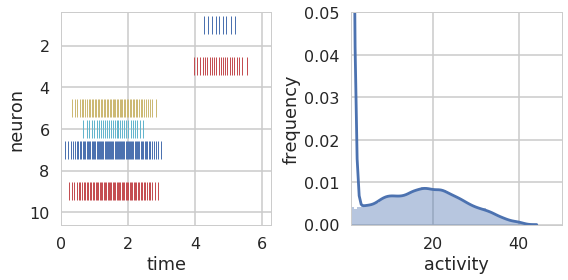

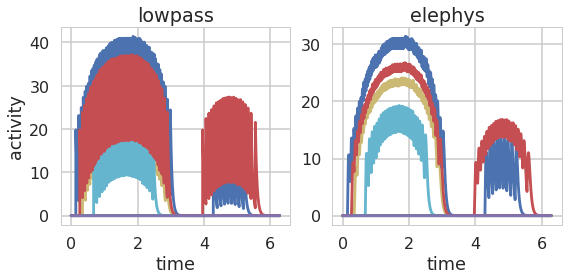

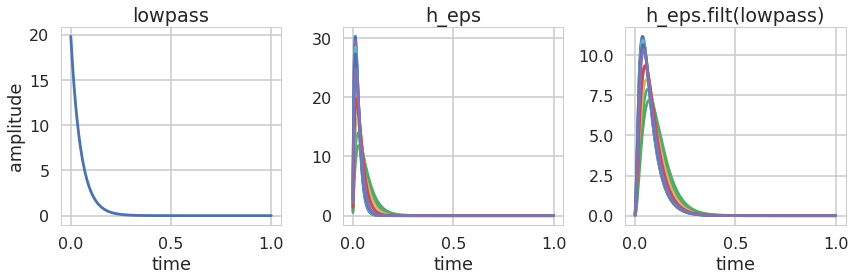

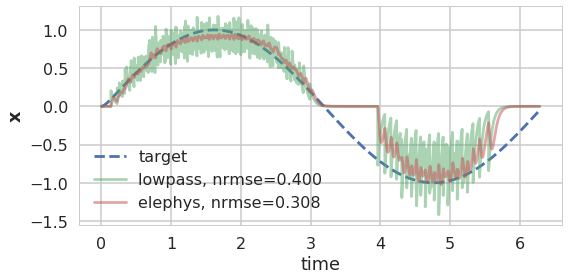

In [11]:
n_neurons = 10
t = 2*np.pi
max_evals = 100

save_dir='/home/pduggins/nengo_bioneurons/nengo_bioneurons/tests/data/double_optimize_polezero_prebio/'
save_file='bio_test.npz'
    
d_lpf = np.zeros((n_neurons, 1))
d_eps = np.zeros((n_neurons, 1))
h_eps = []

d_lpf, d_eps, h_eps = pre_bio_decoder_opt(
    d_lpf,
    d_eps,
    h_eps,
    t=t,
    n_neurons=n_neurons,
    save_dir=save_dir,
    save_file=save_file,
    n_zeros=0,
    n_poles=2,
    z_min=-1e0,
    z_max=1e0,
    p_min=-1e2,
    p_max=-1e0,
    optimize=True,
    plot=True)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:50.                                                 


/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[  8.98391099e-01  -1.76640213e+00]
 [  9.48443733e-04   9.99101031e-01]], B=[[  9.48443733e-04]
 [  4.82688207e-07]], C=[[   -8.26107884  1848.50860395]], D=[[ 0.0074704]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[  8.51031376e-01  -5.60380836e+00]
 [  9.24020232e-04   9.97122826e-01]], B=[[  9.24020232e-04]
 [  4.74421482e-07]], C=[[  -26.629654    5942.84363389]], D=[[ 0.02007574]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/n

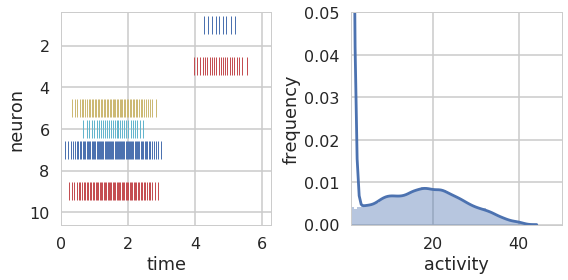

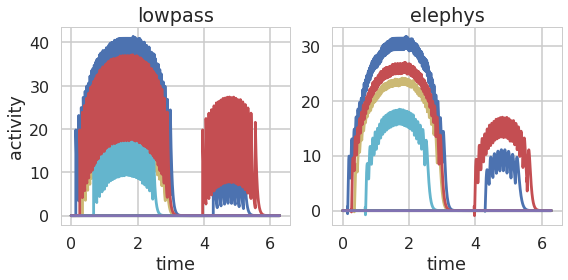

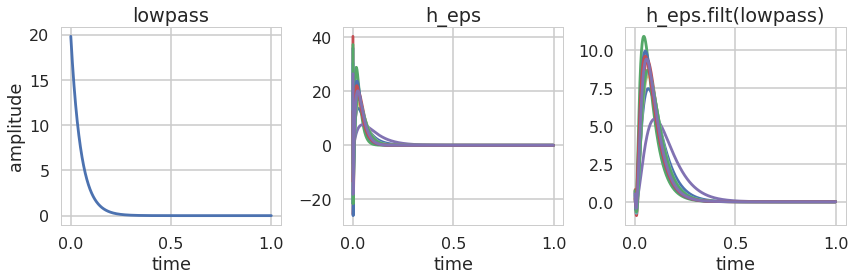

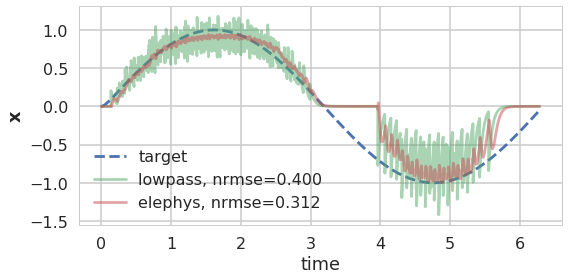

In [22]:
n_neurons = 10
t = 2*np.pi
max_evals = 100

save_dir='/home/pduggins/nengo_bioneurons/nengo_bioneurons/tests/data/double_optimize_polezero_prebio/'
save_file='zeros_2_poles_2.npz'
    
d_lpf = np.zeros((n_neurons, 1))
d_eps = np.zeros((n_neurons, 1))
h_eps = []

d_lpf, d_eps, h_eps = pre_bio_decoder_opt(
    d_lpf,
    d_eps,
    h_eps,
    t=t,
    n_neurons=n_neurons,
    save_dir=save_dir,
    save_file=save_file,
    n_zeros=2,
    n_poles=2,
    z_min=1e1,
    z_max=1e3,
    p_min=-1e2,
    p_max=-1e0,
    optimize=True,
    plot=True)

# Encoder, Decoder, and Filter Optimization

In [22]:
def pre_bio_double_opt(
    d_lpf,
    d_eps,
    h_eps,
    syn_weights=None,
    t=1,
    n_neurons=10,
    n_syn=1,
    signal='sin',
    freq=1,
    amp=1,
    sec='tuft',
    taus={'network': 0.05,
          'readout': 0.05},
    regs={'pre-bio': 0.1,
          'bio-out': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    neuron_type=BahlNeuron(bias_method='weights_fixed'),
    save_dir='/home/pduggins/nengo_bioneurons/nengo_bioneurons/tests/data/double_optimize_zeropole_prebio/',
    save_file='default.npz',
    eta=0,
    n_zeros=0,
    n_poles=1,
    z_min=-1e0,
    z_max=1e0,
    p_min=-1e-1,
    p_max=-1e-2,
    learn=True,
    optimize=True,
    plot=True):
    
    norm, norm_s, norm_f = norms(signal, freq, amp, seeds['ss'], taus['network'], t)
    
    pre_kwargs = dict(
        n_neurons=100,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'])
    
    lif_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'],
        label='lif')
    
    conn_kwargs = dict(
        sec=sec,
        n_syn=n_syn,
        syn_type='ExpSyn',
        tau_list=[taus['network']],
        synapse=taus['network'],
        seed=seeds['cs'])
    
    bio_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=Uniform(-1, 1),  # doesn't affect
        gain=Uniform(0, 0),
        bias=Uniform(0, 0),
        neuron_type=neuron_type,
        seed=seeds['es'],
        label='bio')
    
    # Build a network to collect encoders, gains, biases from target LIF
    with nengo.Network(seed=seeds['ns']) as pre_model:
        pre = nengo.Ensemble(**pre_kwargs)
        lif = nengo.Ensemble(**lif_kwargs)
        pre_lif = nengo.Connection(pre, lif, **conn_kwargs)
    sim = nengo.Simulator(pre_model, seed=seeds['ss'])
    d_pre = sim.data[pre_lif].weights.T
    e_target = sim.data[lif].encoders
    syn_encoders_init = np.zeros((n_neurons, 100, n_syn))
    for bio in range(syn_encoders_init.shape[0]):
        syn_encoders_init[bio] = e_target[bio] * np.ones((100, n_syn))
    
    # Simulate the full network with the encoder learning rule
    with nengo.Network(seed=seeds['ns']) as model:
        u = make_stimulus(signal, freq, amp, seeds['ss'])
        pre = nengo.Ensemble(**pre_kwargs)
        bio = nengo.Ensemble(**bio_kwargs)
        lif = nengo.Ensemble(**lif_kwargs)

        nengo.Connection(u, pre, synapse=None, transform=1.0/norm_s, seed=seeds['cs'])
        pre_bio = nengo.Connection(pre, bio, syn_weights=syn_weights, **conn_kwargs)
        pre_lif = nengo.Connection(pre, lif, **conn_kwargs)
        
        if learn:
            enc_node = EncoderNode(
                pre_bio,
                n_neurons,
                n_syn,
                1,
                d_pre,
                eta,  # learning rate
                seeds['ls'], # learning seed
                syn_encoders_init=syn_encoders_init)
            pre_bio.learning_node = enc_node
            nengo.Connection(bio.neurons, enc_node[0:n_neurons], synapse=taus['readout'])  # a_bio
            nengo.Connection(lif.neurons, enc_node[n_neurons:2*n_neurons], synapse=taus['readout'])  # a_lif
        
        p_target = nengo.Probe(u, synapse=None)
        p_spk_bio = nengo.Probe(bio.neurons, synapse=None)
        p_act_bio = nengo.Probe(bio.neurons, synapse=taus['readout'])
        p_act_lif = nengo.Probe(lif.neurons, synapse=taus['readout'])
        p_lpf = nengo.Probe(bio, synapse=taus['readout'], solver=NoSolver(d_lpf))
        p_lif = nengo.Probe(lif, synapse=taus['readout'])
#         p_eps = nengo.Probe(bio, synapse=h_eps, solver=NoSolver(d_eps))  # todo: support synapse list

    with nengo.Simulator(model, seed=seeds['ss']) as sim:
        sim.run(t)

    target = nengo.Lowpass(taus['readout']).filt(sim.data[p_target])
    spikes = sim.data[p_spk_bio]
    act_lpf = sim.data[p_act_bio]
    act_lif = sim.data[p_act_lif]
    xhat_lpf = sim.data[p_lpf]
    xhat_lif = sim.data[p_lif]
    nrmse_lpf = nrmse(xhat_lpf, target=target)
    nrmse_lif = nrmse(xhat_lif, target=target)
    
    if optimize:  # solve for h_elephys and d_elephys
        np.savez(save_dir+save_file, spikes=spikes, target=target)
        h_eps, d_eps = optimize_elephys(
            save_dir+save_file,
            n_neurons,
            taus['readout'],
            n_zeros=n_zeros,
            n_poles=n_poles,
            z_min=z_min,
            z_max=z_max,
            p_min=p_min,
            p_max=p_max,
            reg=regs['bio-out'],
            max_evals=max_evals,
            normalize=True,
            seed=seeds['ls'])
        
    act_eps = np.zeros_like(act_lpf)
    for n in range(n_neurons):
        act_eps[:,n] = h_eps[n].filt(act_lpf[:,n])
    xhat_eps = np.dot(act_eps, d_eps)
    nrmse_eps = nrmse(xhat_eps, target=target)
        
    x_bins_lpf, hz_means_lpf, hz_stds_lpf = bin_activities_values_1d(target, act_lpf, n_neurons=n_neurons)
    x_bins_eps, hz_means_eps, hz_stds_eps = bin_activities_values_1d(target, act_eps, n_neurons=n_neurons)
    x_bins_lif, hz_means_lif, hz_stds_lif = bin_activities_values_1d(target, act_lif, n_neurons=n_neurons)

    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
        rasterplot(sim.trange(), spikes, ax=ax1)
        ax1.set(xlabel='time', ylabel='neuron')
        sns.distplot(np.ravel(act_lpf), ax=ax2)
        ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
        
        cmap = sns.color_palette('hls', n_neurons)
        fig, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(12, 8), sharey=True)
        for n in range(n_neurons):
            ax4.plot(x_bins_lif, hz_means_lif[n], c=cmap[n])
            ax4.fill_between(x_bins_lif,
                hz_means_lif[n]+hz_stds_lif[n],
                hz_means_lif[n]-hz_stds_lif[n],
                alpha=0.5, facecolor=cmap[n])
            ax5.plot(x_bins_lpf, hz_means_lpf[n], c=cmap[n])
            ax5.fill_between(x_bins_lpf,
                hz_means_lpf[n]+hz_stds_lpf[n],
                hz_means_lpf[n]-hz_stds_lpf[n],
                alpha=0.5, facecolor=cmap[n])
            ax6.plot(x_bins_eps, hz_means_eps[n], c=cmap[n])
            ax6.fill_between(x_bins_eps,
                hz_means_eps[n]+hz_stds_eps[n],
                hz_means_eps[n]-hz_stds_eps[n],
                alpha=0.5, facecolor=cmap[n])
        ax4.set(xlim=((-1,1)), ylim=((0, 50)), xlabel='$\mathbf{x}$', ylabel='activity (Hz)', title='lif')
        ax5.set(xlim=((-1,1)), ylim=((0, 50)), xlabel='$\mathbf{x}$', title='lowpass')
        ax6.set(xlim=((-1,1)), ylim=((0, 50)), xlabel='$\mathbf{x}$', title='elephys')
        plt.tight_layout()
        
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        ax.plot(sim.trange(), target, label='target', linestyle='--')
        ax.plot(sim.trange(), xhat_lif, alpha=0.5, label='lif, nrmse=%.3f' %nrmse_lif)
        ax.plot(sim.trange(), xhat_lpf, alpha=0.5, label='lowpass, nrmse=%.3f' %nrmse_lpf)
        ax.plot(sim.trange(), xhat_eps, alpha=0.5, label='elephys, nrmse=%.3f' %nrmse_eps)
        ax.set(xlabel='time', ylabel='$\mathbf{x}$')
        ax.legend(loc='lower left')
        plt.tight_layout()
        
        plt.show()


    d_lpf_new = LstsqL2(reg=regs['bio-out'])(act_lpf, target)[0]
    syn_weights_new = sim.data[pre_bio].weights
                
    return d_lpf_new, d_eps, h_eps, syn_weights_new

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:16:19.                                                 


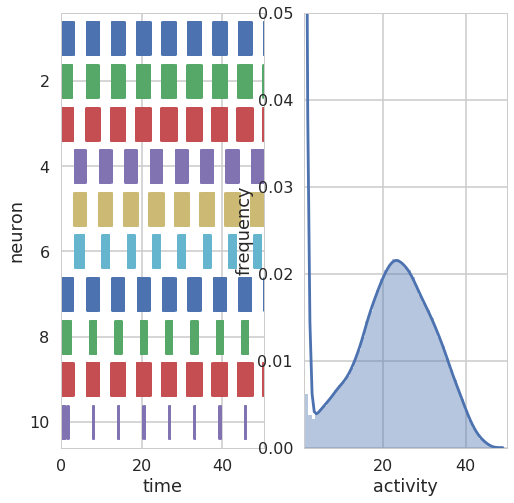

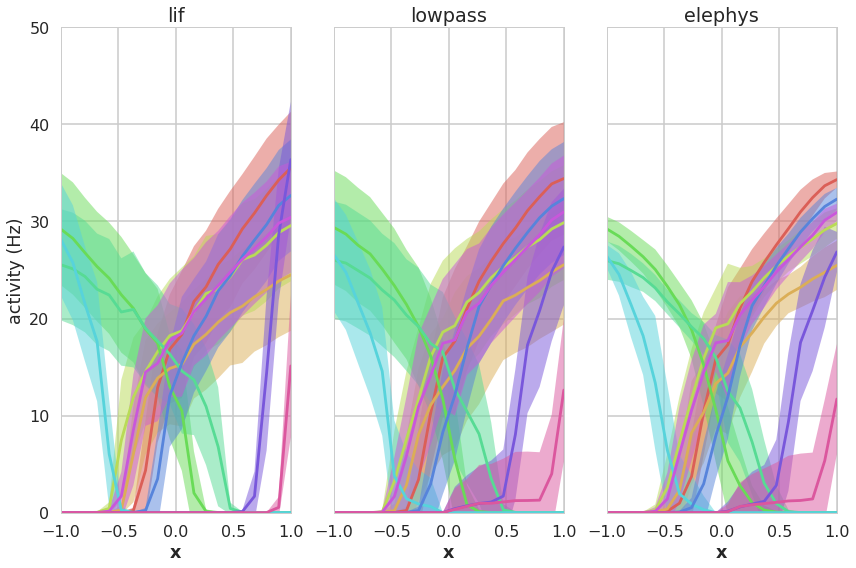

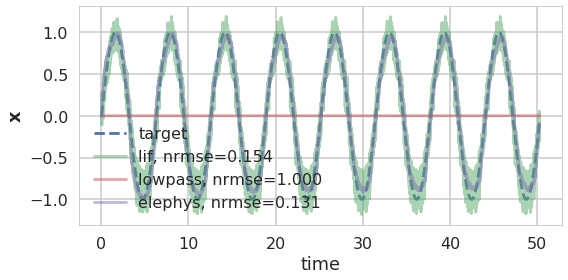

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:02:02.                                                 


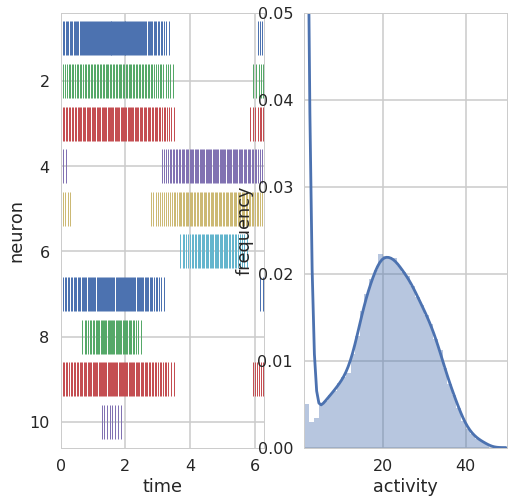

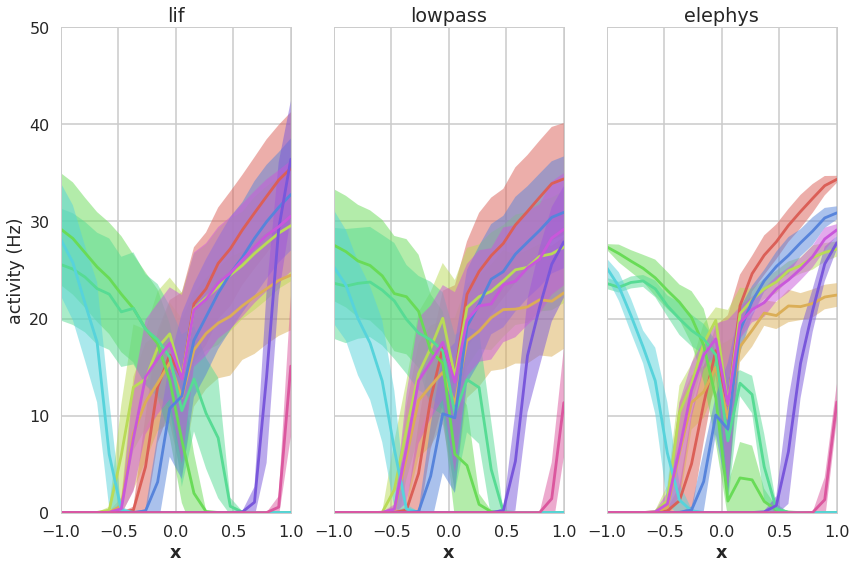

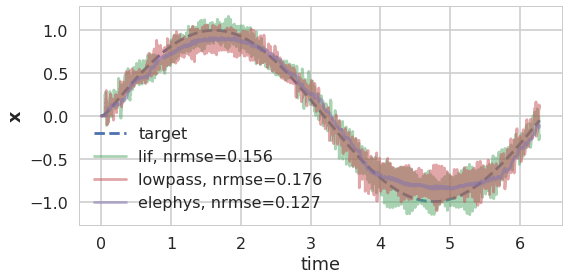

Building finished in 0:00:01.                                                   
Building finished in 0:00:01.                                                   
Simulating finished in 0:01:18.                                                 


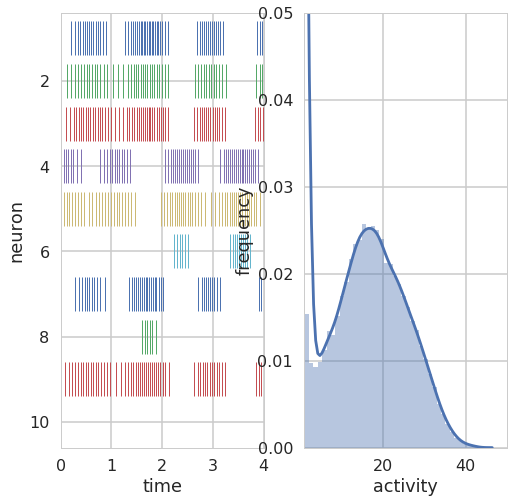

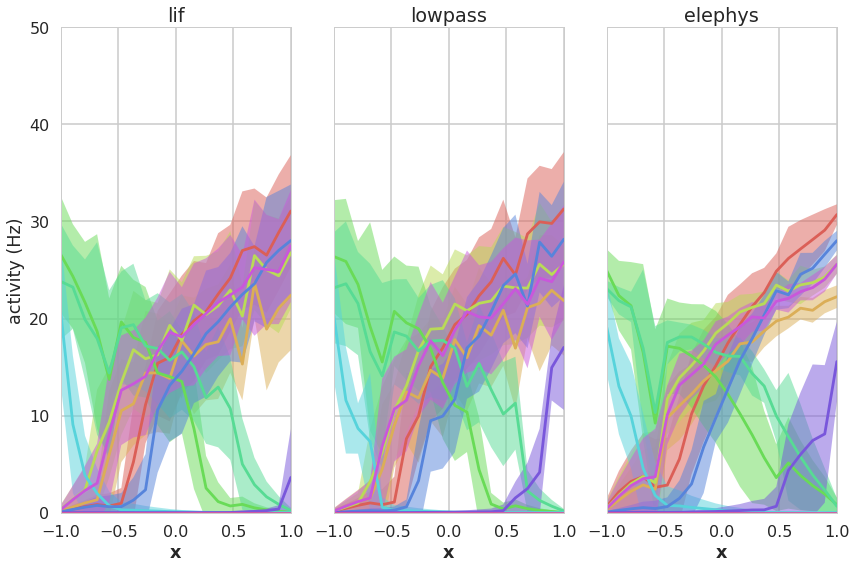

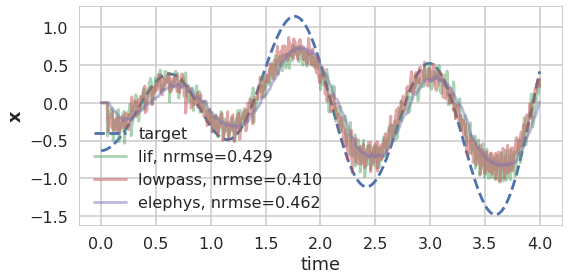

In [26]:
n_neurons = 10
max_evals = 100
n_syn = 2

save_dir='/home/pduggins/nengo_bioneurons/nengo_bioneurons/tests/data/double_optimize_polezero_prebio/'
save_file='double_opt.npz'
    
d_lpf = np.zeros((n_neurons, 1))
d_eps = np.zeros((n_neurons, 1))
h_eps = []
syn_weights_init = np.zeros((n_neurons, 100, n_syn))

d_lpf, d_eps, h_eps, syn_weights = pre_bio_double_opt(
    d_lpf,
    d_eps,
    h_eps,
    syn_weights_init,
    t=16*np.pi,
    n_neurons=n_neurons,
    save_dir=save_dir,
    save_file=save_file,
    n_syn=n_syn,
    eta=2e-3,
    n_zeros=2,
    n_poles=2,
    z_min=1e1,
    z_max=1e3,
    p_min=-1e2,
    p_max=-1e0,
    optimize=True,
    learn=True,
    plot=True)

_, _, _, _ = pre_bio_double_opt(
    d_lpf,
    d_eps,
    h_eps,
    syn_weights,
    t=2*np.pi,
    n_neurons=n_neurons,
    n_syn=n_syn,
    optimize=False,
    learn=False,
    plot=True)

_, _, _, _ = pre_bio_double_opt(
    d_lpf,
    d_eps,
    h_eps,
    syn_weights,
    t=4,
    n_neurons=n_neurons,
    n_syn=n_syn,
    signal='white_noise',
    optimize=False,
    learn=False,
    plot=True)